# Road Defect Detection with YOLOv8

This notebook trains a YOLOv8 object detection model to detect road surface defects such as:
- Longitudinal cracks
- Transverse cracks
- Alligator cracks
- Potholes
- Line cracks
- Block cracks

## Pipeline:
1. Install YOLOv8 and dependencies
2. Upload and unzip dataset
3. Configure model parameters
4. Train using YOLOv8
5. Evaluate on validation set
6. Run predictions on test set
7. Download output files for visualization and reuse

## Evaluation Metrics:
- mAP50 (mean average precision at 0.5 IoU)
- mAP50-95 (mean average precision across IoU thresholds)
- Precision & Recall


### INSTALL DEPENDENCIES

In [1]:
# Install YOLOv8
!pip install --quiet ultralytics

### PREPARE DATA

In [2]:
import os
import shutil

# Copy dataset to writable location
if not os.path.exists("/kaggle/working/data"):
    shutil.copytree("/kaggle/input/merged-road-defect/merged", "/kaggle/working/data")

# Verify contents
!ls /kaggle/working/data

annotations  data.yaml	images	labels


In [9]:
# Write data.yaml with correct paths and class names
yaml_text = """
train: /kaggle/working/data/images/train
val: /kaggle/working/data/images/val
test: /kaggle/working/data/images/test

names:
  0: longitudinal_crack
  1: transverse_crack
  2: alligator_crack
  3: pothole
  4: line_crack
  5: block_crack
"""
with open("/kaggle/working/data.yaml", "w") as file:
    file.write(yaml_text.strip())

# Double check it saved
!cat /kaggle/working/data.yaml

train: /kaggle/working/data/images/train
val: /kaggle/working/data/images/val
test: /kaggle/working/data/images/test

names:
  0: longitudinal_crack
  1: transverse_crack
  2: alligator_crack
  3: pothole
  4: line_crack
  5: block_crack

In [10]:
# Remove empty, invalid, or out-of-bound bounding boxes in the training/validation/test label .txt files.
import glob

LABEL_DIR = "/kaggle/working/data/labels"

def is_label_valid(label_path):
    try:
        with open(label_path, "r") as f:
            lines = f.readlines()
        if not lines:
            return False
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                return False
            cls, x, y, w, h = map(float, parts)
            if cls < 0 or x < 0 or y < 0 or w <= 0 or h <= 0 or x > 1 or y > 1 or w > 1 or h > 1:
                return False
        return True
    except:
        return False

# Remove invalid files in train, val, and test
for split in ["train", "val", "test"]:
    label_files = glob.glob(f"{LABEL_DIR}/{split}/*.txt")
    for file in label_files:
        if not is_label_valid(file):
            os.remove(file)
            print(f"Removed: {file}")


### TRAIN THE YOLOv8 MODEL

In [11]:
from ultralytics import YOLO

# CONFIG
MODEL = "yolov8s.pt"
DATA_PATH = "/kaggle/working/data.yaml"
EPOCHS = 20
IMG_SIZE = 640
BATCH = 32
EXPERIMENT_NAME = "road_defects_yolov8"

In [12]:
model = YOLO(MODEL)

model.train(
    data=DATA_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    name=EXPERIMENT_NAME,
    patience=10,
    lr0=0.005,
    lrf=0.01,
    mixup=0.1,
    cutmix=0.1,
    erasing=0.5,
    hsv_s=0.7,
    translate=0.2,
    mosaic=1.0,
    dropout=0.1,
)

Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.1, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.5, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_defects_yolov85, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0

train: Scanning /kaggle/working/data/labels/train... 22761 images, 13 backgrounds, 0 corrupt: 100%|██████████| 22774/22774 [00:16<00:00, 1419.50it/s]


train: New cache created: /kaggle/working/data/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1123.1±441.5 MB/s, size: 67.6 KB)


val: Scanning /kaggle/working/data/labels/val... 2844 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2846/2846 [00:02<00:00, 1246.15it/s]


val: New cache created: /kaggle/working/data/labels/val.cache
Plotting labels to runs/detect/road_defects_yolov85/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/road_defects_yolov85
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.98G      2.009      3.394      1.881         92        640: 100%|██████████| 712/712 [06:15<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.76it/s]


                   all       2846       6059      0.194      0.183      0.108     0.0389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.84G      1.939      2.694      1.844         79        640: 100%|██████████| 712/712 [06:19<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


                   all       2846       6059        0.3      0.276      0.209     0.0837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.79G      1.893      2.622      1.807        108        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.72it/s]


                   all       2846       6059       0.29      0.257      0.175     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       6.7G      1.861      2.561      1.784         81        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


                   all       2846       6059      0.379      0.319       0.26      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.78G      1.819      2.481      1.752         87        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.77it/s]


                   all       2846       6059       0.41      0.362      0.314      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.79G       1.78      2.415      1.722         99        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


                   all       2846       6059      0.427      0.353      0.323      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.78G      1.748      2.362      1.701         99        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.76it/s]


                   all       2846       6059      0.403       0.37      0.323       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.75G      1.722      2.317       1.68         74        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


                   all       2846       6059       0.45      0.378      0.359      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.75G      1.706       2.28      1.669         77        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.78it/s]


                   all       2846       6059      0.451      0.393      0.376      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       6.7G      1.682      2.243      1.648         72        640: 100%|██████████| 712/712 [06:16<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


                   all       2846       6059      0.467      0.411      0.386       0.18
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.75G      1.726      2.139      1.686         33        640: 100%|██████████| 712/712 [06:11<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


                   all       2846       6059      0.468      0.412        0.4      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.75G      1.696      2.085      1.671         35        640: 100%|██████████| 712/712 [06:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


                   all       2846       6059       0.49      0.434      0.418      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.75G      1.683      2.038      1.653         42        640: 100%|██████████| 712/712 [06:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25<00:00,  1.80it/s]


                   all       2846       6059      0.497      0.439      0.427      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.83G      1.652      1.995      1.636         55        640: 100%|██████████| 712/712 [06:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


                   all       2846       6059      0.494       0.44      0.437      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.75G      1.642      1.955      1.627         52        640: 100%|██████████| 712/712 [06:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.83it/s]


                   all       2846       6059      0.507      0.452       0.45      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.75G      1.617      1.907      1.603         55        640: 100%|██████████| 712/712 [06:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.80it/s]


                   all       2846       6059      0.519      0.454      0.458      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.79G      1.602      1.867       1.59         51        640: 100%|██████████| 712/712 [06:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


                   all       2846       6059      0.522      0.467      0.467       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.75G      1.585      1.835      1.582         45        640: 100%|██████████| 712/712 [06:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


                   all       2846       6059      0.521      0.475      0.473      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.75G      1.557      1.787      1.556         57        640: 100%|██████████| 712/712 [06:09<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.81it/s]


                   all       2846       6059      0.531      0.478      0.487      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.75G      1.545      1.762      1.552         37        640: 100%|██████████| 712/712 [06:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24<00:00,  1.82it/s]


                   all       2846       6059      0.538      0.477      0.492      0.255

20 epochs completed in 2.222 hours.
Optimizer stripped from runs/detect/road_defects_yolov85/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/road_defects_yolov85/weights/best.pt, 22.5MB

Validating runs/detect/road_defects_yolov85/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26<00:00,  1.67it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2846       6059      0.537      0.477      0.492      0.254
    longitudinal_crack        747       1243       0.53      0.582       0.57      0.305
      transverse_crack        594       1108      0.555      0.511      0.529      0.253
       alligator_crack        790        993      0.621      0.592      0.642      0.336
               pothole        351        671      0.594      0.435      0.486      0.215
            line_crack        681       1238      0.449      0.298        0.3      0.168
           block_crack        576        806      0.475      0.445      0.424       0.25
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/road_defects_yolov85


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d817c927750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

### EVALUATE THE MODEL

In [13]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

# Load model
model = YOLO("runs/detect/road_defects_yolov85/weights/best.pt") 
metrics = model.val()

# Overall Evaluation Metrics
print("\n Overall Evaluation Metrics")
print(f"{'Precision:':<20} {metrics.box.mp:.3f}")
print(f"{'Recall:':<20} {metrics.box.mr:.3f}")
print(f"{'mAP@0.5:':<20} {metrics.box.map50:.3f}")
print(f"{'mAP@0.5:0.95:':<20} {metrics.box.map:.3f}")

# Tell user where to find confusion matrix (from val results)
print("\n Confusion Matrix and PR curve saved automatically to your YOLOv8 run directory.")

# Per-Class Breakdown
print("\n Per-Class Performance (Precision, Recall, mAP@0.5, mAP@0.5:0.95):\n")
try:
    per_class = pd.DataFrame({
        "Class": list(metrics.names.values()),
        "Precision": metrics.box.p,
        "Recall": metrics.box.r,
        "mAP@0.5": metrics.box.ap50,
        "mAP@0.5:0.95": metrics.box.ap
    })
    print(per_class.to_string(index=False, formatters={
        "Precision": "{:.3f}".format,
        "Recall": "{:.3f}".format,
        "mAP@0.5": "{:.3f}".format,
        "mAP@0.5:0.95": "{:.3f}".format
    }))
except Exception as e:
    print(" Could not generate per-class breakdown:", e)


Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2019.1±1508.8 MB/s, size: 230.2 KB)


val: Scanning /kaggle/working/data/labels/val.cache... 2844 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2846/2846 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 89/89 [00:39<00:00,  2.28it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2846       6059      0.542      0.474      0.492      0.255
    longitudinal_crack        747       1243      0.534      0.578       0.57      0.307
      transverse_crack        594       1108       0.56      0.504      0.529      0.253
       alligator_crack        790        993      0.625      0.591      0.642      0.336
               pothole        351        671      0.592      0.429      0.486      0.215
            line_crack        681       1238      0.459      0.298      0.301      0.169
           block_crack        576        806       0.48      0.443      0.424      0.249
Speed: 0.4ms preprocess, 9.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/road_defects_yolov852

 Overall Evaluation Metrics
Precision:           0.542
Recall:              0.474
mAP@0.5:             0.492
mAP@0.5:0.95:        0.255

 Confusion Matrix and PR curve saved automatically to your YOLOv8 run directory.

 Per-Class Performance (

### Final Evaluation on Test Set

In [15]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

# Load model
model = YOLO("runs/detect/road_defects_yolov85/weights/best.pt")

# Evaluate on the test set
metrics = model.val(data="/kaggle/working/data.yaml", split='test')

# Print summary metrics
print("\n Overall Evaluation Metrics (Test Set)")
print(f"{'Precision:':<20} {metrics.box.mp:.3f}")
print(f"{'Recall:':<20} {metrics.box.mr:.3f}")
print(f"{'mAP@0.5:':<20} {metrics.box.map50:.3f}")
print(f"{'mAP@0.5:0.95:':<20} {metrics.box.map:.3f}")

# Per-class breakdown
try:
    per_class = pd.DataFrame({
        "Class": list(metrics.names.values()),
        "Precision": metrics.box.p,
        "Recall": metrics.box.r,
        "mAP@0.5": metrics.box.ap50,
        "mAP@0.5:0.95": metrics.box.ap
    })
    print("\n Per-Class Performance:\n")
    print(per_class.to_string(index=False, formatters={
        "Precision": "{:.3f}".format,
        "Recall": "{:.3f}".format,
        "mAP@0.5": "{:.3f}".format,
        "mAP@0.5:0.95": "{:.3f}".format
    }))
except Exception as e:
    print(" Could not generate per-class breakdown:", e)



Ultralytics 8.3.159 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1777.5±540.3 MB/s, size: 98.6 KB)


val: Scanning /kaggle/working/data/labels/test... 2846 images, 0 backgrounds, 3 corrupt: 100%|██████████| 2846/2846 [00:02<00:00, 1415.74it/s]

val: /kaggle/working/data/images/test/11466_DJI_20230707094956_0244_640_07_06.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0078]
val: /kaggle/working/data/images/test/11772_DJI_20230707095006_0253_640_00_06.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0047]
val: /kaggle/working/data/images/test/8985_DJI_20230707094615_0034_640_06_06.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0063]
val: New cache created: /kaggle/working/data/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 178/178 [00:37<00:00,  4.72it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       2843       6079       0.55      0.488        0.5      0.255
    longitudinal_crack        746       1295      0.561      0.569      0.556       0.29
      transverse_crack        586       1126      0.532       0.48      0.495      0.226
       alligator_crack        814       1043      0.643      0.634      0.667      0.358
               pothole        325        596      0.563      0.453      0.496      0.222
            line_crack        670       1188      0.492      0.332      0.336      0.191
           block_crack        571        831      0.506      0.458      0.448      0.244
Speed: 0.3ms preprocess, 9.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val

📈 Overall Evaluation Metrics (Test Set)
Precision:           0.550
Recall:              0.488
mAP@0.5:             0.500
mAP@0.5:0.95:        0.255

🔎 Per-Class Performance:

             Class Precision Recall mAP@0.5 mAP@0.5:0.95
longitudinal_crack     0.561 

### Run Predictions & View Sample Outputs


 Sample Predictions:



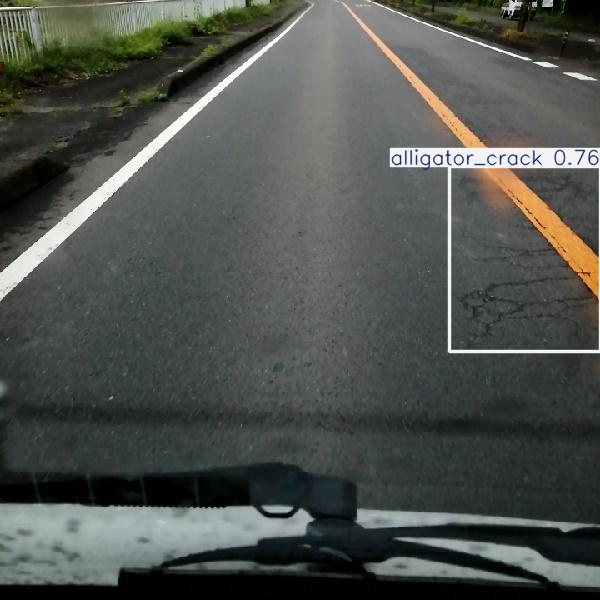

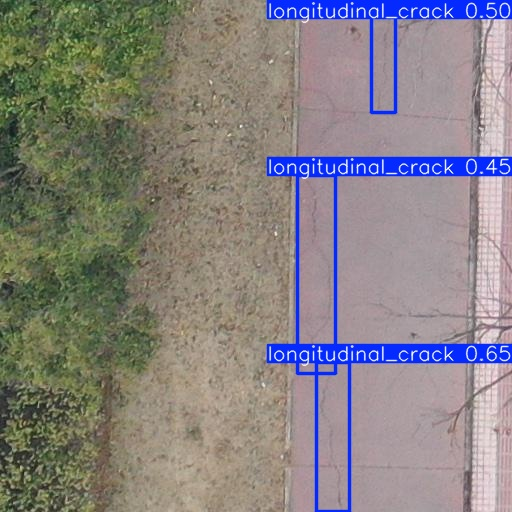

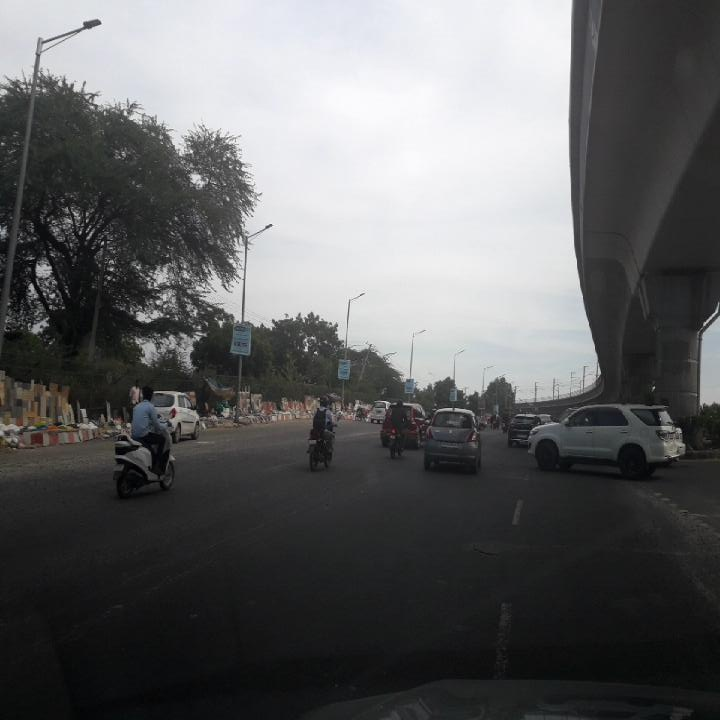

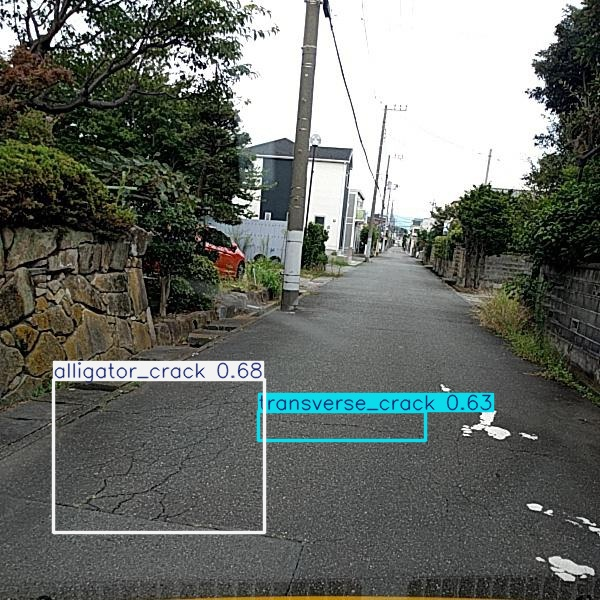

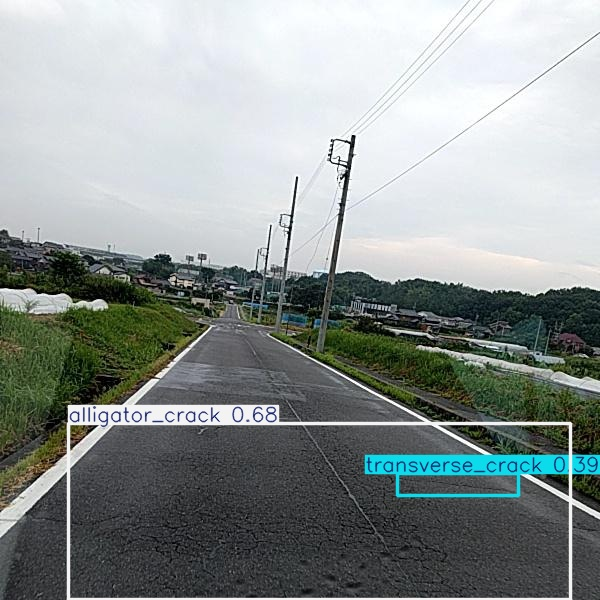

In [24]:
results = model.predict(
    source="/kaggle/working/data/images/test",
    conf=0.25,
    save=True,
    save_txt=True,
    save_conf=True,
    stream=True
)

# Display sample predicted images
import os
from IPython.display import Image, display

pred_dir = "runs/detect/predict"
images = os.listdir(pred_dir)

print("\n Sample Predictions:\n")
for img_name in images[100:105]:
    display(Image(filename=os.path.join(pred_dir, img_name)))